# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgbm
from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import time
import warnings
warnings.filterwarnings('ignore')

**Датасет**

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Описание данных**

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Предобработка данных**

Удаляем следующие столбцы, так как эти признаки не потребуются для построения модели:

DateCrawled, NumberOfPictures, PostalCode, LastSeen

In [5]:
data = data.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen'], axis=1)

Сбросим индексы после удаления

In [6]:
data = data.reset_index(drop=True)

**Работа со столбцами**

Разберем столбцы, которые нуждаются в нашем вмешательстве

**Price**

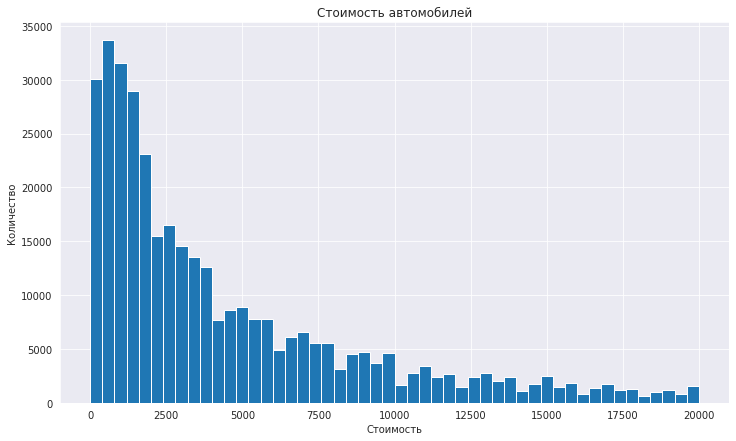

In [7]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('Стоимость автомобилей')
plt.xlabel('Стоимость')
plt.ylabel('Количество')
plt.show()

In [8]:
data.loc[data['Price'] < 2500]['Price'].count()

167033

Чуть меньше половины всех данных сосредоточены в диапазоне цен до 2500 евро

На минимальной стоимости будут совсем плохие автомобили, годящиеся только на детали, но удалять половину данных тоже не выход. Исключим автомобили со стоимостью неже 100 евро

In [9]:
data.loc[data['Price'] < 100]['Price'].count()

13314

In [10]:
data = data.query('Price> 99')

In [11]:
data.loc[data['Price'] < 100]['Price'].count()

0

**VehicleType**

In [12]:
data.VehicleType.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [13]:
print("Обьявления с незаполненным типом кузова:", len(data.loc[data['VehicleType'].isna()])) 

Обьявления с незаполненным типом кузова: 32612


Удалять не будем, переименнуем в "неизвестно"

In [14]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

In [15]:
data.VehicleType.unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [16]:
data.VehicleType.isna().sum()

0

**RegistrationYear**

In [17]:
data.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936,
       1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928,
       5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500, 1602,
       7800, 1947, 1927, 7100, 8200, 1946])

Есть даже автомобили из будущего 

In [18]:
print("Колличество объявлений с неправельным годом:",len(data.loc[(data['RegistrationYear'] > 2022) | (data['RegistrationYear'] < 1900)]))

Колличество объявлений с неправельным годом: 115


Остановимся на машинах от 1900 года и до 2022, так как только начало 2023 и могут попасться некоректные обьявления 

In [19]:
data = data.loc[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1900)]

In [20]:
data.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1966,
       1975, 1963, 1964, 1960, 1958, 1967, 1956, 1941, 1962, 1929, 1957,
       1940, 1949, 1937, 1951, 1959, 1953, 1954, 1950, 1948, 1952, 1932,
       1942, 1935, 1933, 1936, 1923, 1930, 1944, 1943, 1938, 1934, 1928,
       1931, 1947, 1927, 1946])

**Gearbox**

In [21]:
print("Обьявления с незаполненным типом коробки передач:", len(data.loc[data['Gearbox'].isna()])) 

Обьявления с незаполненным типом коробки передач: 14600


In [22]:
data.query('Gearbox.isna()')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00
16,300,unknown,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00
37,1500,unknown,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00
69,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
354288,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16 00:00:00
354305,3500,unknown,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00
354329,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00
354338,180,unknown,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00


In [23]:
data.Gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

Можно было попробовать заменить на значения из аналогичных моделей авто, но тот же Polo может быть как с автоматической, так и с механической коробкой передач, проще удалить пропуски

In [24]:
data.dropna(subset=['Gearbox'], inplace=True)

In [25]:
data['Gearbox'].isna().sum()

0

**Power**

In [26]:
data.Power.describe()

count    312725.000000
mean        115.742729
std         184.968993
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: Power, dtype: float64

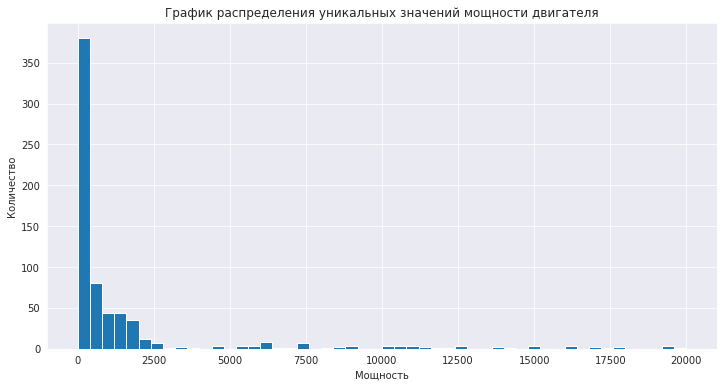

In [27]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности двигателя')
plt.ylabel('Количество')
plt.xlabel('Мощность')
plt.show()

Имеются значения Power равные 0 и больше 2000 что являеться некорректным, 

In [28]:
len(data.loc[(data['Power'] > 2000) | (data['Power'] <= 0)])

22391

Удалим данные о мощности дигателя свыше 2000 л.с. и менее 15 л.с.

In [29]:
data=data.query('Power > 15 & Power < 2000')

**Model**

In [30]:
print("Обьявления с незаполненной моделью:", len(data.loc[data['Model'].isna()])) 

Обьявления с незаполненной моделью: 10259


Модель - это важный фактор построения цены автомобиля, заполнять пропуски будет некоректно

In [31]:
data.dropna(subset=['Model'], inplace=True)

In [32]:
data['Model'].isna().sum()

0

**Kilometer**

In [33]:
data['Kilometer'].isna().sum()

0

**RegistrationMonth**

Для построения модели этот столбец не важен, можно удалить

In [34]:
data = data.drop(['RegistrationMonth'], axis=1)

**FuelType**

In [35]:
data['FuelType'].isna().sum()

11816

In [36]:
data.FuelType.unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [37]:
data.FuelType.value_counts()

petrol      177977
gasoline     84896
lpg           4359
cng            460
hybrid         178
other           68
electric        38
Name: FuelType, dtype: int64

Пропуски в FuelType заменю на среднее по моделям

In [38]:
data['FuelType'] = data['FuelType'].fillna(data.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [39]:
data.FuelType.value_counts()

petrol      187519
gasoline     87170
lpg           4359
cng            460
hybrid         178
other           68
electric        38
Name: FuelType, dtype: int64

**Brand**

In [40]:
data['Brand'].isna().sum()

0

In [41]:
data.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

Все хорошо

**Repaired**

In [42]:
data['Repaired'].isna().sum()

36936

In [43]:
data.Repaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [44]:
data.Repaired.value_counts()

no     216213
yes     26643
Name: Repaired, dtype: int64

Заполним пропуски как N/A

In [45]:
data['Repaired']=data['Repaired'].fillna('N/A')

In [46]:
data.Repaired.value_counts()

no     216213
N/A     36936
yes     26643
Name: Repaired, dtype: int64

**DateCreated**

In [47]:
data['DateCreated'].isna().sum()

0

Приведём к формату datetime

In [48]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')

Позже посчитал, что эта информация не пригодится для будущих моделей

In [49]:
data = data.drop(['DateCreated'], axis=1)

**Итого пропусков**

In [50]:
data.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Отлично, пропусков в данных нет

**Проверка на явные дубликаты**

In [51]:
data.duplicated().sum()

39761

In [52]:
data = data.drop_duplicates()
data.duplicated().sum()

0

**Вывод подготовки данных**

- Отобраны признаки, необходимые для построения моделей
- Признаки ненужные для дальнейшего построения моделей были удалены
- Пропуски были удалены или заполнены на основе имеющейся инфрмации
- Неправдоподобные значения в признаках были удалены
- Явные дубликаты в данных были удалены

## Обучение моделей

In [53]:
cat_data = data

**Кодирование категориальных признаков**

**Прямое кодирование**

In [54]:
def dum(data, column):
    df = pd.get_dummies(data[column], prefix=column, drop_first=True)
    data = data.drop(column, axis=1)
    return data.join(df)

In [55]:
data = dum(data, 'VehicleType')
data = dum(data, 'Gearbox')
data = dum(data, 'FuelType')
data = dum(data, 'Repaired')

**Применим кодирование категориальных данных в цифровые значения методом OrdinalEncoder**

In [56]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data),
                            columns=data.columns)

**Подготовим выборки для обучения моделей**

In [57]:
RANDOM_STATE=12345
target = data_ordinal['Price']
features = data_ordinal.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

**Проверим размер выборки**

In [58]:
train_sample=features_train.shape[0]/features.shape[0]
test_sample=target_test.shape[0]/target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


**Применим масштабирование с помощью StandardScaler**

In [59]:
numeric = ['RegistrationYear', 'Power', 'Model', 'Kilometer', 'Brand']

In [60]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 
print(features_train.head())

        RegistrationYear     Power     Model  Kilometer     Brand  \
23412           1.542497 -0.731962 -0.028962  -2.903163  0.914032   
84791           0.460823  0.327056  0.873699   0.532638  1.298954   
8685           -0.311801 -1.159285  0.281328   0.532638 -0.779626   
146330         -0.002751 -0.880596 -0.353355   0.532638  0.298156   
91889           1.233448  0.884434  0.873699  -0.612629  1.298954   

        VehicleType_convertible  VehicleType_coupe  VehicleType_other  \
23412                       0.0                0.0                0.0   
84791                       0.0                0.0                0.0   
8685                        0.0                0.0                0.0   
146330                      0.0                0.0                0.0   
91889                       0.0                0.0                0.0   

        VehicleType_sedan  VehicleType_small  ...  VehicleType_wagon  \
23412                 0.0                1.0  ...                0.0   
84

**Посмотрим на результат**

In [61]:
data_ordinal.head()

,Price,RegistrationYear,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_no,Repaired_yes
0,2386.0,69.0,147.0,117.0,11.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,584.0,66.0,59.0,116.0,12.0,37.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1180.0,73.0,53.0,101.0,9.0,31.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,262.0,60.0,86.0,11.0,12.0,2.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,794.0,69.0,93.0,8.0,12.0,25.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


**Приступим к обучению моделей**

In [62]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

**Linear Regression**

In [79]:
%%time
start = time.time()
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
end = time.time()
t_lr=round(end-start,2)

CPU times: user 231 ms, sys: 120 ms, total: 351 ms
Wall time: 357 ms


In [85]:
%%time
start = time.time()
pred_lr_model = lr_model.predict(features_train)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 28.7 ms, sys: 15.7 ms, total: 44.4 ms
Wall time: 10.8 ms


In [86]:
mse_lr_model = mean_squared_error(target_train, pred_lr_model)
rmse_lr_model = rmse(target_train, pred_lr_model)
print("RMSE для модели LR на тренировочной выборке:", rmse_lr_model)

RMSE для модели LR на тестовой выборке: 543.14


In [116]:
scores = cross_val_score(lr_model, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
final_score = scores.mean()
print(final_score)

-295127.2677898471


**CatBoost**

Найдем лучшие гиперпараметры для модели, используя GridSearchCV

Обучим модель

In [100]:
%%time
start = time.time()
model_cat = CatBoostRegressor(random_state=RANDOM_STATE,learning_rate=0.4, verbose=100,n_estimators=1000)
model_cat.fit(features_train, target_train, eval_set=(features_train,target_train))
end = time.time()
t_cat=round(end-start,2)

0:	learn: 685.8945120	test: 685.8945120	best: 685.8945120 (0)	total: 26.4ms	remaining: 26.3s
100:	learn: 305.0795034	test: 305.0795034	best: 305.0795034 (100)	total: 2.65s	remaining: 23.6s
200:	learn: 292.6999685	test: 292.6999685	best: 292.6999685 (200)	total: 5.36s	remaining: 21.3s
300:	learn: 285.8508379	test: 285.8508379	best: 285.8508379 (300)	total: 8.06s	remaining: 18.7s
400:	learn: 280.9701234	test: 280.9701234	best: 280.9701234 (400)	total: 10.7s	remaining: 15.9s
500:	learn: 276.9895167	test: 276.9895167	best: 276.9895167 (500)	total: 13.3s	remaining: 13.2s
600:	learn: 273.7572367	test: 273.7572367	best: 273.7572367 (600)	total: 15.8s	remaining: 10.5s
700:	learn: 270.9720365	test: 270.9720365	best: 270.9720365 (700)	total: 18.3s	remaining: 7.8s
800:	learn: 268.8311143	test: 268.8311143	best: 268.8311143 (800)	total: 20.7s	remaining: 5.15s
900:	learn: 266.7678078	test: 266.7678078	best: 266.7678078 (900)	total: 23.1s	remaining: 2.54s
999:	learn: 264.7622771	test: 264.7622771	be

In [101]:
%%time
start = time.time()
predict_cat_model=model_cat.predict(features_train)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: user 205 ms, sys: 39 µs, total: 205 ms
Wall time: 203 ms


In [102]:
mse_cat_model = mean_squared_error(target_train, predict_cat_model)
rmse_cat_model = rmse(target_train, predict_cat_model)
print("RMSE для модели CatBoost на тренировочной выборке:", rmse_cat_model)

RMSE для модели LR на тренировочной выборке: 264.76


**LightGBM**

In [95]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=RANDOM_STATE, learning_rate=0.4, objective='rmse')
model_LGB.fit(features_train, target_train, verbose=100, eval_set=(features_train,target_train))
end = time.time()
t_lgb=round(end-start,2)

[100]	training's rmse: 289.684
[200]	training's rmse: 275.692
[300]	training's rmse: 267.169
[400]	training's rmse: 260.79
[500]	training's rmse: 255.836
[600]	training's rmse: 252.121
[700]	training's rmse: 248.169
[800]	training's rmse: 244.944
[900]	training's rmse: 242.126
[1000]	training's rmse: 239.386
CPU times: user 1min 22s, sys: 422 ms, total: 1min 22s
Wall time: 1min 23s


In [97]:
%%time
start = time.time()
predict_LGB_model = model_LGB.predict(features_train)
end = time.time()
t_lgb_p=round(end-start,2)

CPU times: user 15.5 s, sys: 12.3 ms, total: 15.5 s
Wall time: 15.5 s


In [98]:
mse_LGB_model = mean_squared_error(target_train, predict_LGB_model)
rmse_LGB_model = rmse(target_train, predict_LGB_model)
print("RMSE для модели LightGBM на тренировочной выборке:", rmse_LGB_model)

RMSE для модели LR на тренировочной выборке: 239.39


## Анализ моделей

In [117]:
column=['RMSE модели','Скорость обучения, сек.','Скорость предсказания, сек.']

comparison_tabl = pd.DataFrame(index=['RMSE модели','Скорость обучения, сек.', 'Скорость предсказания, сек.'], columns=['LinearRegression','CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = rmse_lr_model, t_lr, t_lr_p
comparison_tabl['CatBoostRegressor'] = rmse_cat_model, t_cat, t_cat_p
comparison_tabl['LightGBM'] = rmse_LGB_model, t_lgb,t_lgb_p

comparison_tabl.T.style.highlight_min(color='green',subset=column).highlight_max(color='red',subset=column)


,RMSE модели,"Скорость обучения, сек.","Скорость предсказания, сек."
LinearRegression,543.140000,0.280000,0.010000
CatBoostRegressor,264.760000,27.000000,0.200000
LightGBM,239.390000,83.510000,15.470000


**Вывод**

- LinearRegression показал самую высокую скорость обучения и при этом саму низкую точность
- Самое лучшее качество модели получилось у LGBMRegressor, но ее время обучения довольно большое секкунд.
- CatBoost предсказала совсем немного хуже, чем LGBMRegressor, но обучение заняло заняло меньше времени
- Основываясь на этих данных можем рекомендовать модель CatBoostRegressor

## Тестирование лучшей модели

In [136]:
%%time
start = time.time()
model_cat_test = CatBoostRegressor(random_state=RANDOM_STATE,learning_rate=0.4, verbose=100,n_estimators=1000)
model_cat_test.fit(features_train, target_train)
end = time.time()
tt_cat=round(end-start,2)

0:	learn: 685.8945120	total: 25.8ms	remaining: 25.8s
100:	learn: 305.0795034	total: 2.42s	remaining: 21.5s
200:	learn: 292.6999685	total: 4.68s	remaining: 18.6s
300:	learn: 285.8508379	total: 7.04s	remaining: 16.4s
400:	learn: 280.9701234	total: 9.32s	remaining: 13.9s
500:	learn: 276.9895167	total: 11.7s	remaining: 11.6s
600:	learn: 273.7572367	total: 14s	remaining: 9.32s
700:	learn: 270.9720365	total: 16.5s	remaining: 7.02s
800:	learn: 268.8311143	total: 18.8s	remaining: 4.67s
900:	learn: 266.7678078	total: 21.1s	remaining: 2.32s
999:	learn: 264.7622771	total: 23.5s	remaining: 0us
CPU times: user 23.8 s, sys: 124 ms, total: 23.9 s
Wall time: 24.8 s


In [137]:
%%time
start = time.time()
predict_cat_test=model_cat_test.predict(features_test)
end = time.time()
tt_cat_p=round(end-start,2)

CPU times: user 70.4 ms, sys: 3.93 ms, total: 74.3 ms
Wall time: 72.6 ms


In [140]:
mse_cat_test = mean_squared_error(target_test, predict_cat_test)
rmse_cat_test = rmse(target_test, predict_cat_test)
print("RMSE для модели CatBoost на тестовой выборке:", rmse_cat_test)

RMSE для модели CatBoost на тестовой выборке: 297.46


In [143]:
column=['RMSE модели','Скорость обучения, сек.','Скорость предсказания, сек.']

comparison_tabl = pd.DataFrame(index=['RMSE модели','Скорость обучения, сек.', 'Скорость предсказания, сек.'], columns=['Тестовая','Тренировочная'])
comparison_tabl['Тестовая'] = rmse_cat_test, tt_cat, tt_cat_p
comparison_tabl['Тренировочная'] = rmse_cat_model, t_cat, t_cat_p


comparison_tabl.T.style.highlight_min(color='green',subset=column).highlight_max(color='red',subset=column)

,RMSE модели,"Скорость обучения, сек.","Скорость предсказания, сек."
Тестовая,297.460000,24.760000,0.070000
Тренировочная,264.760000,27.000000,0.200000
